## Imports

In [6]:
def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

def set_size_square(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions for square subplots to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt

    # Figure height in inches, calculated to make subplots square
    # The height of the total figure is the width multiplied by the ratio of rows to columns.
    fig_height_in = fig_width_in * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

# import matplotlib as mpl
# mpl.use('pgf')
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import re
import sys
import pandas as pd
import plotly.graph_objects as go
from scipy.optimize import curve_fit


plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": r"""
\usepackage[T1]{fontenc}
\usepackage{amsmath}
\usepackage{amsfonts}
\def\mathdefault#1{#1}
"""
})
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10
# The amsmath package is needed for \text{}, fontenc is for font encoding
# Fix the LaTeX preamble to define mathdefault and include necessary packages
plt.rcParams["text.latex.preamble"] = r"""
\usepackage[T1]{fontenc}
\usepackage{amsmath}
\usepackage{amsfonts}
\def\mathdefault#1{#1}
"""
# ...existing code...
def sci_tex(val, sig=3):
    """
    Format number with sig significant figures as LaTeX 'a×10^{b}' (no $ added).
    Falls back to plain number if no exponent.
    """
    s = f"{val:.{sig}g}"
    if 'e' in s or 'E' in s:
        base, exp = s.lower().split('e')
        exp_int = int(exp)  # handles +00, -03, etc.
        return rf"{base}\times 10^{{{exp_int}}}"
    return s
# ...existing code...
doc_size=441.01773

## Inp Generators

### Angle Series - 800eV

In [3]:
# source input file (original location)
src_path = Path(r"Sample.inp")
text = src_path.read_text(encoding="utf-8")
lines = text.splitlines()
if not lines:
    raise SystemExit("source file is empty")

first = lines[0]
tokens = list(re.finditer(r"\S+", first))
if len(tokens) < 4:
    raise SystemExit("first line has fewer than 4 tokens; cannot locate 4th column")

out_dir = Path.cwd()  # save to local path (current working directory)

for angle in range(0, 91, 5):
    angle_tok = f"{angle:.2f}"
    m = tokens[3]  # 4th token (0-based index 3)
    start, end = m.start(), m.end()
    width = end - start
    repl = angle_tok.rjust(width) if len(angle_tok) <= width else angle_tok
    new_first = first[:start] + repl + first[end:]
    new_text = "\n".join([new_first] + lines[1:]) + ("\n" if text.endswith("\n") else "")
    out_path = out_dir / f"Angle Series - 800eV/input files/CSimulation-{angle}.inp"
    out_path.write_text(new_text, encoding="utf-8")

print(f"Generated {len(range(0 , 91, 5))} files in {out_dir}")

Generated 19 files in /workspaces/codespaces-jupyter/Simulation


### Threshold Energy

In [4]:
# ...existing code above...

# Threshold Energy (updated)
src_path = Path("Sample.inp")
text = src_path.read_text(encoding="utf-8")
lines = text.splitlines()
if not lines:
    raise SystemExit("source file is empty")

first = lines[0]
token_matches = list(re.finditer(r"\S+", first))
if len(token_matches) < 8:
    raise SystemExit("first line has fewer than 8 tokens")

IDX_ENERGY = 2     # original energy token (e.g. 800.00)
IDX_SHEATH = 6     # original sheath token (e.g. 2400.00)

# Original token widths (for padding only if new shorter)
energy_width = token_matches[IDX_ENERGY].end() - token_matches[IDX_ENERGY].start()
sheath_width = token_matches[IDX_SHEATH].end() - token_matches[IDX_SHEATH].start()

out_dir = Path.cwd()
input_dir = out_dir / "Threshold Energy/input files"
input_dir.mkdir(parents=True, exist_ok=True)

min_energy = 800
max_energy = 10000
n_points = 50
energies = np.logspace(np.log10(min_energy), np.log10(max_energy), num=n_points)
energies_int = np.rint(energies).astype(int)
base_energies = sorted(set(energies_int.tolist()))

# Add 20 extra energies between 55 and 60 (inclusive) with two-decimal precision
fine_energies = [round(v, 2) for v in np.linspace(55, 60, 21)]
# Merge and sort
all_energies = sorted(set(base_energies) | set(fine_energies))

def replace_fixed_width(line: str, matches, repl: dict[int, str]) -> str:
    parts = []
    last = 0
    # Prepare spans
    spans = []
    for idx, new_raw in repl.items():
        m = matches[idx]
        start, end = m.start(), m.end()
        width = end - start
        if len(new_raw) < width:
            new_txt = new_raw.ljust(width)
        else:
            new_txt = new_raw  # allow expansion if longer (do NOT truncate)
        spans.append((start, end, new_txt))
    spans.sort(key=lambda x: x[0])
    for start, end, new_txt in spans:
        parts.append(line[last:start])
        parts.append(new_txt)
        last = end
    parts.append(line[last:])
    return "".join(parts)

for energy in all_energies:
    # Ensure float for formatting
    e_val = float(energy)
    energy_str = f"{e_val:.2f}"
    sheath_str = f"{e_val * 3:.2f}"
    # Preserve widths (pad only if shorter; never truncate if longer)
    new_first = replace_fixed_width(first, token_matches, {
        IDX_ENERGY: energy_str,
        IDX_SHEATH: sheath_str
    })
    new_text = "\n".join([new_first] + lines[1:]) + ("\n" if text.endswith("\n") else "")
    # File naming: keep two decimals to distinguish fine points
    fname = f"CSimulation-{e_val:.2f}.inp"
    (input_dir / fname).write_text(new_text, encoding="utf-8")

print(f"Generated {len(all_energies)} files in {input_dir}")
# ...existing

Generated 71 files in /workspaces/codespaces-jupyter/Simulation/Threshold Energy/input files


## Graphs

### 800eV Angle Series

### Threshold Energy

Checking directory: Threshold Energy/Data/CSimulation-1000.00
  No sputtering yield found in Threshold Energy/Data/CSimulation-1000.00/trvmc95.out
Checking directory: Threshold Energy/Data/CSimulation-10000.00
Checking directory: Threshold Energy/Data/CSimulation-101.00
Checking directory: Threshold Energy/Data/CSimulation-1035.00
Checking directory: Threshold Energy/Data/CSimulation-1090.00
Checking directory: Threshold Energy/Data/CSimulation-1148.00
Checking directory: Threshold Energy/Data/CSimulation-116.00
Checking directory: Threshold Energy/Data/CSimulation-1208.00
Checking directory: Threshold Energy/Data/CSimulation-1272.00
Checking directory: Threshold Energy/Data/CSimulation-132.00
Checking directory: Threshold Energy/Data/CSimulation-1340.00
Checking directory: Threshold Energy/Data/CSimulation-1410.00
Checking directory: Threshold Energy/Data/CSimulation-1485.00
Checking directory: Threshold Energy/Data/CSimulation-151.00
Checking directory: Threshold Energy/Data/CSimulat

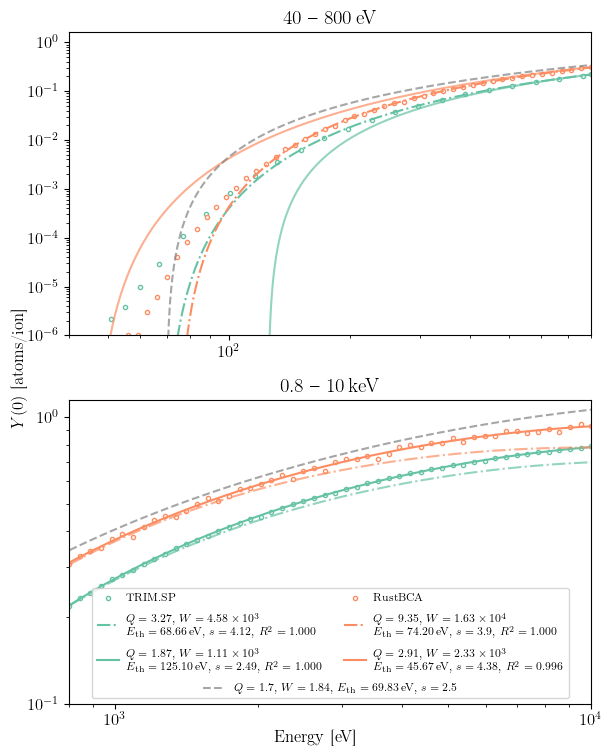

In [27]:
DATA_DIR = Path("Threshold Energy/Data")
if not DATA_DIR.exists():
    print(f"Data directory not found: {DATA_DIR}", file=sys.stderr)
    sys.exit(1)

M_i = 39.948  # Argon ion mass in atomic mass units (amu)
M_t = 12.011  # Carbon target mass in atomic mass units (amu)
A = M_t / M_i 
g = 4 * A / ((A + 1) ** 2) 

yield_re = re.compile(r"SPUTTERING YIELD\(1\)\s*=\s*([+-]?\d+(?:\.\d*)?(?:[Ee][+-]?\d+)?)", re.IGNORECASE)
energy_re = re.compile(r"csimulation[-_]?([0-9]+(?:\.[0-9]+)?)", re.IGNORECASE)

points = []

for d in sorted(DATA_DIR.iterdir()):
    if not d.is_dir():
        continue
    print(f"Checking directory: {d}")
    out_file = d / (d.name + ".out")
    if not out_file.exists():
        outs = list(d.glob("*.out"))
        out_file = outs[0] if outs else None
    if not out_file:
        print(f"  No .out file found in {d}")
        continue
    text = out_file.read_text(errors="ignore")
    m = yield_re.search(text)
    if not m:
        print(f"  No sputtering yield found in {out_file}")
        continue
    try:
        sputter = float(m.group(1))
    except ValueError:
        continue
    # Parse energy from folder name (fallback to parsing from filename if needed)
    energy = None
    m2 = energy_re.search(d.name)
    if m2:
        energy = float(m2.group(1))
    else:
        # try filename
        m3 = energy_re.search(out_file.name)
        if m3:
            energy = float(m3.group(1))
    if energy is None:
        # fallback: try extracting trailing number
        tail = re.search(r"[-_](\d+(?:\.\d+)?)$", d.name)
        if tail:
            energy = float(tail.group(1))
    if energy is None:
        continue
    points.append((energy, sputter))

if not points:
    print("No sputtering yields found.", file=sys.stderr)
    sys.exit(1)

points.sort(key=lambda x: x[0])
energies, yields = zip(*points)

energies = np.array(energies)
yields = np.array(yields)
# --- Begin sputtering yield physical fit (add after you have arrays `energies`, `yields`) ---

# Projectile (ion) = Ar, Target = C (adjust if reversed)
Z1, Z2 = 18, 6
M1, M2 = 39.948, 12.011          # amu
U0 = 7.41                   # surface binding energy (eV) (change or fit)
Q_const = 1.0                    # can be absorbed into fitted Q scale

# Universal nuclear stopping cross section (ZBL-like approximation)
def s_n(eps):
    # Sigmund/ZBL empirical form
    return 3.441 * np.sqrt(eps) * np.log(eps + 2.718) / (1 + 6.355 * np.sqrt(eps) + eps * (6.882 * np.sqrt(eps) - 1.708))

def epsilon(E):
    denom = Z1*Z2 * np.sqrt(Z1**(2/3) + Z2**(2/3))
    return 0.03255 * (M2/(M1+M2)) * E / denom

def k_const():
    num = (M1 + M2)**1.5 * (Z1**(2/3)*np.sqrt(Z2))
    den = (M1**1.5 * M2**0.5) * (Z1**(2/3) + Z2**(2/3))**0.75
    return 0.0793 * num / den

_k = k_const()

def s_e(eps):
    return _k * eps**0.5


r = M2 / M1
if M1 < M2:
    # Eq. (15)
    alpha_star = 0.249 * r**0.56 + 0.0035 * r**1.5
elif M1 > M2:
    # Eq. (16)
    alpha_star = 0.0875 * r**(-0.15) + 0.165 * r
else:
    # M1 == M2: either form converges closely; use first branch
    alpha_star = 0.249 * r**0.56 + 0.0035 * r**1.5


def A_term(W):
    return W / (1 + (M1/7)**3)

def S_n(E):
    eps = epsilon(E)
    pref = 84.78 * Z1*Z2 * (M1/(M1+M2)) / np.sqrt(Z1**(2/3) + Z2**(2/3))
    return pref * s_n(eps)   # eV Å^2 atom^-1 (relative scaling)


def Y_model(E, Q, W, Eth, s):
    """
    Sputtering yield model with s as a fitted exponent.
    For E <= Eth the core factor goes to zero smoothly.
    """
    E = np.asarray(E, dtype=float)
    if Eth < 0:
        return np.zeros_like(E)

    eps = epsilon(E)
    Sn  = S_n(E)
    se  = s_e(eps)
    A   = A_term(W)

    ratio = float(Eth) / np.maximum(E, float(Eth))
    core = (1.0 - np.sqrt(ratio))**s  # s now a free parameter

    denom = 1.0 + A * _k * eps**0.3
    pref  = 0.042 * Q * Q_const * alpha_star / U0
    return pref * (Sn / denom) * core 

if 'E_yamamura' not in globals():
    # Log-spaced energy grid covering both subplot ranges
    E_yamamura = np.logspace(np.log10(40), np.log10(10000), 800)
if not all(v in globals() for v in ['Q_init','W_init','Eth_init','s_init']):
    # Baseline (initial) parameters used for reference curve
    Q_init, W_init, Eth_init, s_init = 1.7, 1.84, 69.83, 2.5

# Data
E_data = energies
Y_data = yields   # normalize by (1+gamma)

# --- SEPARATE FITS FOR EACH ENERGY RANGE ---

# Split data into two ranges
mask_low_data = (E_data >= 40) & (E_data <= 800)
mask_high_data = (E_data >= 800) & (E_data <= 10000)

E_data_low = E_data[mask_low_data]
Y_data_low = Y_data[mask_low_data]
E_data_high = E_data[mask_high_data]
Y_data_high = Y_data[mask_high_data]

# Initial guesses and bounds for both fits
p0 = [1.7, 1.84, 69.83, 2.5]
bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])

# Fit 1: Low energy range (40-800 eV)
if len(E_data_low) > 4:
    popt_low, pcov_low = curve_fit(Y_model, E_data_low, Y_data_low, p0=p0, bounds=bounds, maxfev=50000)
    Q_opt_low, W_opt_low, Eth_opt_low, s_opt_low = popt_low
    perr_low = np.sqrt(np.diag(pcov_low))
    
    # Calculate R² for low energy fit
    residuals_low = Y_data_low - Y_model(E_data_low, *popt_low)
    ss_res_low = np.sum(residuals_low**2)
    ss_tot_low = np.sum((Y_data_low - np.mean(Y_data_low))**2)
    r_squared_low = 1 - ss_res_low/ss_tot_low if ss_tot_low > 0 else np.nan
    
    print("Low energy fit parameters (40-800 eV):")
    print(f" Q   = {sci_tex(Q_opt_low,4)} ± {sci_tex(perr_low[0],2)}")
    print(f" W   = {sci_tex(W_opt_low,4)} ± {sci_tex(perr_low[1],2)}")
    print(f" Eth = {sci_tex(Eth_opt_low,4)} ± {sci_tex(perr_low[2],2)} eV")
    print(f" s   = {sci_tex(s_opt_low,4)} ± {sci_tex(perr_low[3],2)}")
    print(f" R²  = {r_squared_low:.4f}")
else:
    print("Not enough data points for low energy fit")
    popt_low = p0
    r_squared_low = 0

# Fit 2: High energy range (800-10000 eV)
if len(E_data_high) > 4:
    popt_high, pcov_high = curve_fit(Y_model, E_data_high, Y_data_high, p0=p0, bounds=bounds, maxfev=50000)
    Q_opt_high, W_opt_high, Eth_opt_high, s_opt_high = popt_high
    perr_high = np.sqrt(np.diag(pcov_high))
    
    # Calculate R² for high energy fit
    residuals_high = Y_data_high - Y_model(E_data_high, *popt_high)
    ss_res_high = np.sum(residuals_high**2)
    ss_tot_high = np.sum((Y_data_high - np.mean(Y_data_high))**2)
    r_squared_high = 1 - ss_res_high/ss_tot_high if ss_tot_high > 0 else np.nan
    
    print("\nHigh energy fit parameters (800-10000 eV):")
    print(f" Q   = {sci_tex(Q_opt_high,4)} ± {sci_tex(perr_high[0],2)}")
    print(f" W   = {sci_tex(W_opt_high,4)} ± {sci_tex(perr_high[1],2)}")
    print(f" Eth = {sci_tex(Eth_opt_high,4)} ± {sci_tex(perr_high[2],2)} eV")
    print(f" s   = {sci_tex(s_opt_high,4)} ± {sci_tex(perr_high[3],2)}")
    print(f" R²  = {r_squared_high:.4f}")
else:
    print("Not enough data points for high energy fit")
    popt_high = p0
    r_squared_high = 0

# Generate fit curves for each range
E_fit_low = np.linspace(40, 800, 1000)
E_fit_high = np.linspace(800, 10000, 1000)
Y_fit_low = Y_model(E_fit_low, *popt_low)
Y_fit_high = Y_model(E_fit_high, *popt_high)

# --- RustBCA separate fits if data available ---
rust_angle0_file = Path('RustBCA/yields_Ar_on_C_angle0.txt')
if rust_angle0_file.exists():
    try:
        # Load RustBCA data, skipping commented lines
        rust_df = pd.read_csv(rust_angle0_file, sep=r'\s+', comment='#', engine='python')
        
        # Handle different possible column names or use first two columns
        if rust_df.shape[1] >= 2:
            if 'Energy_eV' in rust_df.columns or 'Energy' in rust_df.columns:
                energy_col = 'Energy_eV' if 'Energy_eV' in rust_df.columns else 'Energy'
                rust_energies = rust_df[energy_col].values
            else:
                rust_energies = rust_df.iloc[:, 0].values
                
            if 'Yield_at_per_ion' in rust_df.columns or 'Yield' in rust_df.columns:
                yield_col = 'Yield_at_per_ion' if 'Yield_at_per_ion' in rust_df.columns else 'Yield'
                rust_yields = rust_df[yield_col].values
            else:
                rust_yields = rust_df.iloc[:, 1].values
        else:
            raise ValueError("Insufficient columns in RustBCA file")
            
        rust_energies = rust_energies.astype(float)
        rust_yields = rust_yields.astype(float)
        rust_yields_norm = rust_yields 
        
        # Split RustBCA data into energy ranges
        rust_mask_low = (rust_energies >= 40) & (rust_energies <= 800)
        rust_mask_high = (rust_energies >= 800) & (rust_energies <= 10000)
        
        rust_E_low = rust_energies[rust_mask_low]
        rust_Y_low = rust_yields_norm[rust_mask_low]
        rust_E_high = rust_energies[rust_mask_high]
        rust_Y_high = rust_yields_norm[rust_mask_high]
        
        # Separate fits for RustBCA data
        if len(rust_E_low) > 4:
            try:
                popt_rust_low, pcov_rust_low = curve_fit(Y_model, rust_E_low, rust_Y_low, 
                                                        p0=p0, bounds=bounds, maxfev=50000)
                # Calculate R² for RustBCA low energy fit
                residuals_rust_low = rust_Y_low - Y_model(rust_E_low, *popt_rust_low)
                ss_res_rust_low = np.sum(residuals_rust_low**2)
                ss_tot_rust_low = np.sum((rust_Y_low - np.mean(rust_Y_low))**2)
                r_squared_rust_low = 1 - ss_res_rust_low/ss_tot_rust_low if ss_tot_rust_low > 0 else np.nan
                
                print("\nRustBCA low energy fit parameters (40-800 eV):")
                Q_rust_low, W_rust_low, Eth_rust_low, s_rust_low = popt_rust_low
                perr_rust_low = np.sqrt(np.diag(pcov_rust_low))
                print(f" Q   = {sci_tex(Q_rust_low,4)} ± {sci_tex(perr_rust_low[0],2)}")
                print(f" W   = {sci_tex(W_rust_low,4)} ± {sci_tex(perr_rust_low[1],2)}")
                print(f" Eth = {sci_tex(Eth_rust_low,4)} ± {sci_tex(perr_rust_low[2],2)} eV")
                print(f" s   = {sci_tex(s_rust_low,4)} ± {sci_tex(perr_rust_low[3],2)}")
                print(f" R²  = {r_squared_rust_low:.4f}")
            except Exception as e:
                print(f'RustBCA low energy fit failed: {e}', file=sys.stderr)
                popt_rust_low = None
                r_squared_rust_low = 0
        else:
            popt_rust_low = None
            r_squared_rust_low = 0
            
        if len(rust_E_high) > 4:
            try:
                popt_rust_high, pcov_rust_high = curve_fit(Y_model, rust_E_high, rust_Y_high, 
                                                          p0=p0, bounds=bounds, maxfev=50000)
                # Calculate R² for RustBCA high energy fit
                residuals_rust_high = rust_Y_high - Y_model(rust_E_high, *popt_rust_high)
                ss_res_rust_high = np.sum(residuals_rust_high**2)
                ss_tot_rust_high = np.sum((rust_Y_high - np.mean(rust_Y_high))**2)
                r_squared_rust_high = 1 - ss_res_rust_high/ss_tot_rust_high if ss_tot_rust_high > 0 else np.nan
                
                print("\nRustBCA high energy fit parameters (800-10000 eV):")
                Q_rust_high, W_rust_high, Eth_rust_high, s_rust_high = popt_rust_high
                perr_rust_high = np.sqrt(np.diag(pcov_rust_high))
                print(f" Q   = {sci_tex(Q_rust_high,4)} ± {sci_tex(perr_rust_high[0],2)}")
                print(f" W   = {sci_tex(W_rust_high,4)} ± {sci_tex(perr_rust_high[1],2)}")
                print(f" Eth = {sci_tex(Eth_rust_high,4)} ± {sci_tex(perr_rust_high[2],2)} eV")
                print(f" s   = {sci_tex(s_rust_high,4)} ± {sci_tex(perr_rust_high[3],2)}")
                print(f" R²  = {r_squared_rust_high:.4f}")
            except Exception as e:
                print(f'RustBCA high energy fit failed: {e}', file=sys.stderr)
                popt_rust_high = None
                r_squared_rust_high = 0
        else:
            popt_rust_high = None
            r_squared_rust_high = 0
            
    except Exception as e:
        print(f'Failed to read RustBCA angle0 file: {e}', file=sys.stderr)
        rust_energies = np.array([])
        popt_rust_low = None
        popt_rust_high = None

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=set_size(doc_size, subplots=(2,1), fraction=1.0))

# Choose colors from colormap for consistency
cmap = plt.get_cmap('Set2')
trim_color = cmap(0)   # TRIM.SP
rust_color = cmap(1)   # RustBCA


# --- Left subplot: 40-800 eV ---
# Plot TRIM.SP data and fit on left subplot
trim_points_handle = ax1.scatter(E_data_low, Y_data_low, marker='.', c='white', edgecolors=trim_color, label='TRIM.SP')
trim_fit_label_low = (
    f'$Q={sci_tex(Q_opt_low)}$, $W={sci_tex(W_opt_low)}$\n'
    f'$E_{{\\text{{th}}}}={Eth_opt_low:.2f}\\,$eV, $s={sci_tex(s_opt_low)}$, $R^2={r_squared_low:.3f}$'
)
trim_low_fit_handle = ax1.plot(E_fit_low, Y_fit_low, '-.', color=trim_color, label=trim_fit_label_low)[0]

rust_points_handle = None
rust_low_fit_handle = None
rust_high_fit_handle = None

if rust_angle0_file.exists() and 'rust_E_low' in locals() and len(rust_E_low) > 0:
    rust_points_handle = ax1.scatter(rust_E_low, rust_Y_low, marker='.', c='white', edgecolors=rust_color, label='RustBCA')
    if 'popt_rust_low' in locals() and popt_rust_low is not None:
        Y_rust_fit_low = Y_model(E_fit_low, *popt_rust_low)
        rust_fit_label_low = (
            f'$Q={sci_tex(Q_rust_low)}$, $W={sci_tex(W_rust_low)}$\n'
            f'$E_{{\\text{{th}}}}={Eth_rust_low:.2f}\\,$eV, $s={sci_tex(s_rust_low)}$, $R^2={r_squared_rust_low:.3f}$'
        )
        rust_low_fit_handle = ax1.plot(E_fit_low, Y_rust_fit_low, '-.', color=rust_color, label=rust_fit_label_low)[0]

# Comparison lines (exclude from legend)
ax1.plot(E_fit_low, Y_model(E_fit_low, *popt_high), '-', color=trim_color, alpha=0.7, label='_nolegend_')
if rust_angle0_file.exists() and 'popt_rust_high' in locals() and popt_rust_high is not None:
    ax1.plot(E_fit_low, Y_model(E_fit_low, *popt_rust_high), '-', color=rust_color, alpha=0.7, label='_nolegend_')

# Yamamura left (no legend entry here)
ax1.plot(E_yamamura[(E_yamamura >= 40) & (E_yamamura <= 800)],
         Y_model(E_yamamura[(E_yamamura >= 40) & (E_yamamura <= 800)], Q_init, W_init, Eth_init, s_init),
         '--', color='gray', alpha=0.7, label='_nolegend_')

# --- Right subplot: 800-10000 eV ---
trim_points_high_handle = ax2.scatter(E_data_high, Y_data_high, marker='.', c='white', edgecolors=trim_color, label='_nolegend_')  # no duplicate label
trim_fit_label_high = (
    f'$Q={sci_tex(Q_opt_high)}$, $W={sci_tex(W_opt_high)}$\n'
    f'$E_{{\\text{{th}}}}={Eth_opt_high:.2f}\\,$eV, $s={sci_tex(s_opt_high)}$, $R^2={r_squared_high:.3f}$'
)
trim_high_fit_handle = ax2.plot(E_fit_high, Y_fit_high, '-', color=trim_color, label=trim_fit_label_high)[0]

if rust_angle0_file.exists() and 'rust_E_high' in locals() and len(rust_E_high) > 0:
    # reuse rust_points_handle if already defined; else create
    if rust_points_handle is None:
        rust_points_handle = ax2.scatter(rust_E_high, rust_Y_high, marker='.', c='white', edgecolors=rust_color, label='RustBCA')
    else:
        ax2.scatter(rust_E_high, rust_Y_high, marker='.', c='white', edgecolors=rust_color, label='_nolegend_')
    if 'popt_rust_high' in locals() and popt_rust_high is not None:
        Y_rust_fit_high = Y_model(E_fit_high, *popt_rust_high)
        rust_fit_label_high = (
            f'$Q={sci_tex(Q_rust_high)}$, $W={sci_tex(W_rust_high)}$\n'
            f'$E_{{\\text{{th}}}}={Eth_rust_high:.2f}\\,$eV, $s={sci_tex(s_rust_high)}$, $R^2={r_squared_rust_high:.3f}$'
        )
        rust_high_fit_handle = ax2.plot(E_fit_high, Y_rust_fit_high, '-', color=rust_color, label=rust_fit_label_high)[0]

# Cross low fit on high (exclude)
ax2.plot(E_fit_high, Y_model(E_fit_high, *popt_low), '-.', color=trim_color, alpha=0.7, label='_nolegend_')
if rust_angle0_file.exists() and 'popt_rust_low' in locals() and popt_rust_low is not None:
    ax2.plot(E_fit_high, Y_model(E_fit_high, *popt_rust_low), '-.', color=rust_color, alpha=0.7, label='_nolegend_')

# Yamamura (capture handle)
E_yamamura_high = E_yamamura[(E_yamamura >= 800) & (E_yamamura <= 10000)]
Y_yamamura_high = Y_model(E_yamamura_high, Q_init, W_init, Eth_init, s_init)
yamamura_handle = ax2.plot(E_yamamura_high, Y_yamamura_high, '--', color='gray', alpha=0.7,
                           label=(f'$Q={Q_init}$, $W={W_init}$, $E_{{\\text{{th}}}}={Eth_init}\\,$eV, $s={s_init}$'))[0]

# ---------------- FIXED MANUAL LEGEND ----------------

from matplotlib.patches import Rectangle
_dummy = Rectangle((0,0),0,0, facecolor='none', edgecolor='none')

# Ensure point labels exist
if trim_points_handle.get_label() in ('', '_nolegend_'):
    trim_points_handle.set_label('TRIM.SP')
if rust_points_handle is not None and rust_points_handle.get_label() in ('', '_nolegend_'):
    rust_points_handle.set_label('RustBCA')

# --- LEGEND 1: Main entries (ncol=2) ---
main_rows = [
    (trim_points_handle, rust_points_handle),
    (trim_low_fit_handle, rust_low_fit_handle),
    (trim_high_fit_handle, rust_high_fit_handle),
    (None, None)  # spacer row
]

left_col, right_col = [], []
for left, right in main_rows:
    left_col.append(left if left is not None else _dummy)
    right_col.append(right if right is not None else _dummy)

main_handles = left_col + right_col
main_labels = []
for h in main_handles:
    if h is _dummy:
        main_labels.append('')
    else:
        lab = h.get_label()
        main_labels.append('' if lab in ('', '_nolegend_') else lab)

# Create the first legend and add it to the axis
leg1 = ax2.legend(
    main_handles,
    main_labels,
    ncol=2,
    loc='lower center',
    fontsize=8,
    columnspacing=2.0,
    handletextpad=0.6,
    borderpad=0.5,
    labelspacing=0.9
)
ax2.add_artist(leg1)

# --- LEGEND 2: Centered Yamamura entry ---

leg2 = ax2.legend(
    [yamamura_handle],
    [yamamura_handle.get_label()],
    ncol=1,
    loc='lower center',
    bbox_to_anchor=(0.5, 0), # Manually adjust coordinates for centering
    fontsize=8,
    frameon=False
)


# Add shared x-label using fig.text() instead of individual subplot labels
ax1.set_xlabel('') 
ax2.set_xlabel('')  
ax1.set_ylabel('')  
ax2.set_ylabel('')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax1.set_xlim(40, 800)
ax2.set_xlim(800, 10000)
ax1.set_ylim(bottom=1e-6)
ax2.set_ylim(bottom=1e-1)
ax1.set_title(r'40 -- 800$\,$eV')
ax2.set_title(r'0.8 -- 10$\,$keV')
fig.text(0.5, 0, 'Energy [eV]', ha='center', va='bottom')
fig.text(0, 0.5, r'$Y(0)$ [atoms/ion]', ha='left', va='center', rotation='vertical')

plt.tight_layout()
plt.savefig('ThresholdEnergyComparison.pgf', format='pgf')
plt.show()



Full energy range fit parameters (40-10000 eV):
 Q   = 2.106 ± 0.067
 W   = 1493 ± 1.2e+02
 Eth = 80.26 ± 5.7 eV
 s   = 3.454 ± 0.19
 R²  = 0.9999

RustBCA full energy range fit parameters (40-10000 eV):
 Q   = 2.623 ± 0.22
 W   = 1946 ± 3.6e+02
 Eth = 99.01 ± 12 eV
 s   = 2.655 ± 0.3
 R²  = 0.9993


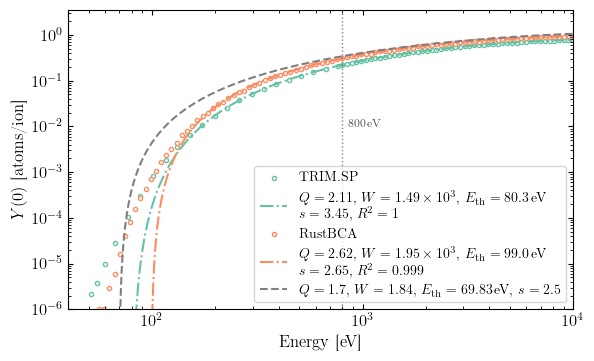

In [17]:
# --- FULL RANGE PLOT WITH SINGLE FIT ---

# Fit the entire dataset (full energy range)
p0_full = [1.7, 1.84, 69.83, 2.5]
bounds_full = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])

try:
    popt_full, pcov_full = curve_fit(Y_model, E_data, Y_data, p0=p0_full, bounds=bounds_full, maxfev=50000)
    Q_opt_full, W_opt_full, Eth_opt_full, s_opt_full = popt_full
    perr_full = np.sqrt(np.diag(pcov_full))
    
    # Calculate R² for full range fit
    residuals_full = Y_data - Y_model(E_data, *popt_full)
    ss_res_full = np.sum(residuals_full**2)
    ss_tot_full = np.sum((Y_data - np.mean(Y_data))**2)
    r_squared_full = 1 - ss_res_full/ss_tot_full if ss_tot_full > 0 else np.nan
    
    print("\nFull energy range fit parameters (40-10000 eV):")
    print(f" Q   = {Q_opt_full:.4g} ± {perr_full[0]:.2g}")
    print(f" W   = {W_opt_full:.4g} ± {perr_full[1]:.2g}")
    print(f" Eth = {Eth_opt_full:.4g} ± {perr_full[2]:.2g} eV")
    print(f" s   = {s_opt_full:.4g} ± {perr_full[3]:.2g}")
    print(f" R²  = {r_squared_full:.4f}")
    
except Exception as e:
    print(f"Full range fit failed: {e}", file=sys.stderr)
    popt_full = p0_full
    r_squared_full = 0

# Generate fit curve for full range
E_fit_full = np.logspace(np.log10(40), np.log10(10000), 2000)
Y_fit_full = Y_model(E_fit_full, *popt_full)

# RustBCA full range fit if data available
if rust_angle0_file.exists() and len(rust_energies) > 4:
    try:
        popt_rust_full, pcov_rust_full = curve_fit(Y_model, rust_energies, rust_yields_norm, 
                                                  p0=p0_full, bounds=bounds_full, maxfev=50000)
        # Calculate R² for RustBCA full range fit
        residuals_rust_full = rust_yields_norm - Y_model(rust_energies, *popt_rust_full)
        ss_res_rust_full = np.sum(residuals_rust_full**2)
        ss_tot_rust_full = np.sum((rust_yields_norm - np.mean(rust_yields_norm))**2)
        r_squared_rust_full = 1 - ss_res_rust_full/ss_tot_rust_full if ss_tot_rust_full > 0 else np.nan
        
        print("\nRustBCA full energy range fit parameters (40-10000 eV):")
        Q_rust_full, W_rust_full, Eth_rust_full, s_rust_full = popt_rust_full
        perr_rust_full = np.sqrt(np.diag(pcov_rust_full))
        print(f" Q   = {Q_rust_full:.4g} ± {perr_rust_full[0]:.2g}")
        print(f" W   = {W_rust_full:.4g} ± {perr_rust_full[1]:.2g}")
        print(f" Eth = {Eth_rust_full:.4g} ± {perr_rust_full[2]:.2g} eV")
        print(f" s   = {s_rust_full:.4g} ± {perr_rust_full[3]:.2g}")
        print(f" R²  = {r_squared_rust_full:.4f}")
        
        Y_rust_fit_full = Y_model(E_fit_full, *popt_rust_full)
    except Exception as e:
        print(f'RustBCA full range fit failed: {e}', file=sys.stderr)
        popt_rust_full = None
        r_squared_rust_full = 0
else:
    popt_rust_full = None

# Create full range plot
plt.figure(figsize=set_size(doc_size))

# Plot TRIM.SP data and fit
plt.scatter(E_data, Y_data, marker='.', c='white', edgecolors=trim_color, label='TRIM.SP')
trim_fit_label_full = (f'$Q={sci_tex(Q_opt_full)}$, $W={sci_tex(W_opt_full)}$, $E_{{\\text{{th}}}}={Eth_opt_full:.1f}\\,$eV\n'
                      f'$s={sci_tex(s_opt_full)}$, $R^2={sci_tex(r_squared_full,3)}$')
plt.plot(E_fit_full, Y_fit_full, '-.', color=trim_color, label=trim_fit_label_full)

# Handle RustBCA data if available
if rust_angle0_file.exists() and len(rust_energies) > 0:
    plt.scatter(rust_energies, rust_yields_norm, marker='.', c='white', edgecolors=rust_color, 
               label='RustBCA')
    
    # If we have a RustBCA fit for full range, plot it
    if popt_rust_full is not None:
        rust_fit_label_full = (f'$Q={sci_tex(Q_rust_full)}$, $W={sci_tex(W_rust_full)}$, $E_{{\\text{{th}}}}={Eth_rust_full:.1f}\\,$eV\n'
                              f'$s={sci_tex(s_rust_full)}$, $R^2={sci_tex(r_squared_rust_full,3)}$')
        plt.plot(E_fit_full, Y_rust_fit_full, '-.', color=rust_color, label=rust_fit_label_full)

# Add Yamamura reference curve for comparison
if 'E_yamamura' in globals():
    Y_yamamura_full = Y_model(E_yamamura, Q_init, W_init, Eth_init, s_init)
    plt.plot(E_yamamura, Y_yamamura_full, '--', color='gray',
             label=f'$Q={Q_init}$, $W={W_init}$, $E_{{\\text{{th}}}}={Eth_init}\\,$eV, $s={s_init}$')

# Format plot
plt.xlabel('Energy [eV]')
plt.ylabel(r'$Y(0)$ [atoms/ion]')
plt.tick_params(axis='both', which='both', direction='in',
                top=True, right=True, bottom=True, left=True)
plt.yscale('log')
plt.xscale('log')
plt.xlim(40, 10000)
plt.ylim(bottom=1e-6)
plt.legend()

# Add vertical lines to show the energy range boundaries used in subplots
plt.axvline(x=800, color='black', linestyle=':', alpha=0.5, linewidth=1)
plt.text(850, 1e-2, r'800$\,$eV', rotation=0, fontsize=8, alpha=0.7)

plt.tight_layout()
plt.savefig('ThresholdEnergyFullRange.pgf', format='pgf')
plt.show()

Checking directory: Angle Series - 800eV/Data/CSimulation-0
Checking directory: Angle Series - 800eV/Data/CSimulation-10
Checking directory: Angle Series - 800eV/Data/CSimulation-15
Checking directory: Angle Series - 800eV/Data/CSimulation-20
Checking directory: Angle Series - 800eV/Data/CSimulation-25
Checking directory: Angle Series - 800eV/Data/CSimulation-30
Checking directory: Angle Series - 800eV/Data/CSimulation-35
Checking directory: Angle Series - 800eV/Data/CSimulation-40
Checking directory: Angle Series - 800eV/Data/CSimulation-45
Checking directory: Angle Series - 800eV/Data/CSimulation-5
Checking directory: Angle Series - 800eV/Data/CSimulation-50
Checking directory: Angle Series - 800eV/Data/CSimulation-55
Checking directory: Angle Series - 800eV/Data/CSimulation-60
Checking directory: Angle Series - 800eV/Data/CSimulation-65
Checking directory: Angle Series - 800eV/Data/CSimulation-70
Checking directory: Angle Series - 800eV/Data/CSimulation-75
Checking directory: Angle 

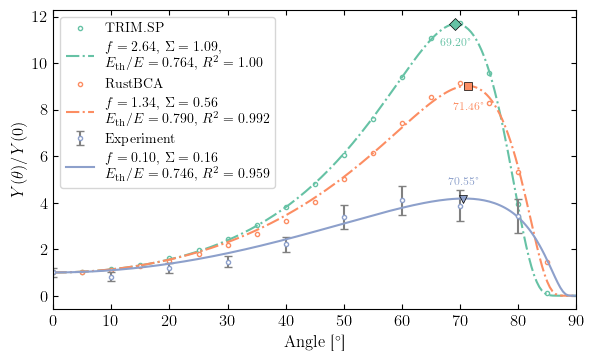

In [23]:
DATA_DIR = Path("Angle Series - 800eV/Data")
if not DATA_DIR.exists():
    print(f"Data directory not found: {DATA_DIR}", file=sys.stderr)
    sys.exit(1)

yield_re = re.compile(r"SPUTTERING YIELD\(1\)\s*=\s*([+-]?\d+(?:\.\d*)?(?:[Ee][+-]?\d+)?)", re.IGNORECASE)
angle_name_re = re.compile(r"csimulation[-_]?([0-9]+(?:\.[0-9]+)?)", re.IGNORECASE)

points = []

for d in sorted(DATA_DIR.iterdir()):
    if not d.is_dir():
        continue
    print(f"Checking directory: {d}")
    out_file = d / (d.name + ".out")
    if not out_file.exists():
        outs = list(d.glob("*.out"))
        out_file = outs[0] if outs else None
    if not out_file:
        print(f"  No .out file found in {d}")
        continue
    text = out_file.read_text(errors="ignore")
    m = yield_re.search(text)
    if not m:
        print(f"  No sputtering yield found in {out_file}")
        continue
    try:
        sputter = float(m.group(1))
    except ValueError:
        continue
    # Parse angle from folder name (fallback to parsing from filename if needed)
    angle = None
    m2 = angle_name_re.search(d.name)
    if m2:
        angle = float(m2.group(1))
    else:
        # try filename
        m3 = angle_name_re.search(out_file.name)
        if m3:
            angle = float(m3.group(1))
    if angle is None:
        # fallback: try extracting trailing number
        tail = re.search(r"[-_](\d+(?:\.\d+)?)$", d.name)
        if tail:
            angle = float(tail.group(1))
    if angle is None:
        continue
    points.append((angle, sputter))

if not points:
    print("No sputtering yields found.", file=sys.stderr)
    sys.exit(1)

points.sort(key=lambda x: x[0])
angles, yields = zip(*points)

angles = np.array(angles)
yields = np.array(yields)

# find value at (or nearest to) 0 degrees and normalize by it
idx0 = np.argmin(np.abs(angles - 0.0))
base = yields[idx0]
if abs(base) < 1e-12:
    print("Warning: yield at 0° is zero or nearly zero; skipping normalization", file=sys.stderr)
    yields_norm = yields
else:
    yields_norm = yields / base

def yamamura_extended(theta_deg, f, sigma, eth_e_ratio):
    """
    Extended Yamamura sputter yield function, vectorized and safe for fitting.
    theta_deg: incident angle in degrees (scalar or array)
    f, sigma: fitting parameters
    eth_e_ratio: The ratio Eth/E (must be 0 <= eth_e_ratio < 1)
    """
    theta = np.asarray(theta_deg, dtype=float)
    theta_rad = np.deg2rad(theta)
    cos_theta = np.cos(theta_rad)
    cos_theta = np.where(np.abs(cos_theta) < 1e-9, 1e-9, cos_theta)  # avoid divide-by-zero
    x = 1.0 / cos_theta

    # If eth_e_ratio outside valid range return large values so optimizer avoids it
    if not (0 <= eth_e_ratio < 1):
        return np.full_like(x, np.inf, dtype=float)

    sqrt_eth_e_ratio = np.sqrt(eth_e_ratio)

    term1 = (x ** f) * np.exp(-sigma * (x - 1))
    term2 = (1 - sqrt_eth_e_ratio / x) / (1 - sqrt_eth_e_ratio)
    return term1 * term2

# initial guesses and bounds
p0 = [1.5, 1.0, 0.02]              # [f, sigma, eth_e_ratio]
bounds = ([0.0, 0.0, 0.0], [10.0, 10.0, 0.999])

# Use existing angles and yields_norm data
angle_data = angles
norm_yield_data = yields_norm

# Fit 2: Extended Yamamura with Eth/E ratio
# Initial guesses for f, sigma, eth_e_ratio. Bounds to keep ratio between 0 and 1.
popt2, pcov2 = curve_fit(yamamura_extended, angle_data, norm_yield_data, p0=[1, 1, 0.1], bounds=([-np.inf, -np.inf, 0], [np.inf, np.inf, 1]))
f_opt2, sigma_opt2, eth_e_ratio_opt2 = popt2
residuals2 = norm_yield_data - yamamura_extended(angle_data, *popt2)
ss_res2 = np.sum(residuals2**2)
ss_tot2 = np.sum((norm_yield_data - np.mean(norm_yield_data))**2)
r_squared2 = 1 - (ss_res2 / ss_tot2)

# Create the scatter plot
plt.figure(figsize=set_size(441.01773))

# choose a colormap for consistent matching colors
cmap = plt.get_cmap('Set2')
trim_color = cmap(0)   # TRIM.SP
rust_color = cmap(1)   # RustBCA
exp_color = cmap(2)    # Experimental

plt.scatter(angle_data, norm_yield_data, color='white',edgecolors=trim_color, marker='.', label='TRIM.SP')

# Plot the fitted curves
angle_fit = np.linspace(min(angle_data), 90, 200)

fit_label2 = (f'$f = {f_opt2:.2f}$, ' +
             r'$\Sigma = ' + f'{sigma_opt2:.2f}$, ' + '\n'
             f'$E_{{\\text{{th}}}}/E = {eth_e_ratio_opt2:.3f}$, $R^2 = {r_squared2:.2f}$')

# Plot second fit and find its peak
yamamura_fit2 = yamamura_extended(angle_fit, *popt2)
plt.plot(angle_fit, yamamura_fit2, '-.', color=trim_color, label=fit_label2)

# Find and highlight peak of second fit
peak2_idx = np.argmax(yamamura_fit2)
peak2_angle = angle_fit[peak2_idx]
peak2_yield = yamamura_fit2[peak2_idx]
plt.plot(peak2_angle, peak2_yield, 'D', color=trim_color, markersize=6, markeredgecolor='black', markeredgewidth=0.5)
plt.annotate(f'{peak2_angle:.2f}°', 
            xy=(peak2_angle, peak2_yield), 
            xytext=(0, -10),
            textcoords='offset points',
            ha='center', va='top',
            fontsize=8, color=trim_color)

# --- Overlay RustBCA data (yields_Ar_on_C_800eV) and fit ---
rust_file = Path('RustBCA/yields_Ar_on_C_800eV.txt')
if rust_file.exists():
    # load, skipping commented lines that start with #
    try:
        rust_df = pd.read_csv(rust_file, sep=r'\s+', comment='#', engine='python')
        # If file has header 'Angle_deg\tYield_at_per_ion' pandas will parse it; otherwise fallback to two columns
        if rust_df.shape[1] >= 2 and 'Angle_deg' in rust_df.columns:
            rust_angles = rust_df['Angle_deg'].values
            # try common yield column names or take second column
            yield_col = None
            for cname in ['Yield_at_per_ion','Yield','Yield_at_per_ion ']:
                if cname in rust_df.columns:
                    yield_col = cname
                    break
            if yield_col is None:
                yield_col = rust_df.columns[1]
            rust_yields = rust_df[yield_col].values
        else:
            vals = rust_df.values
            rust_angles = vals[:,0].astype(float)
            rust_yields = vals[:,1].astype(float)
    except Exception as e:
        print(f'Failed to read RustBCA file: {e}', file=sys.stderr)
        rust_angles = np.array([]); rust_yields = np.array([])

    if rust_angles.size and rust_yields.size:
        # normalize by RustBCA value at (or nearest to) 0 degrees
        idx0_r = np.argmin(np.abs(rust_angles - 0.0))
        base_r = rust_yields[idx0_r] if abs(rust_yields[idx0_r]) > 1e-12 else 1.0
        rust_norm = rust_yields / base_r
        # plot RustBCA points
        plt.scatter(rust_angles, rust_norm, color='white', edgecolors=rust_color, marker='.', label='RustBCA')
        # attempt a separate fit for RustBCA data
        try:
            popt_r, pcov_r = curve_fit(
                yamamura_extended,
                rust_angles,
                rust_norm,
                p0=[1, 1, 0.1],
                bounds=([-np.inf, -np.inf, 0], [np.inf, np.inf, 1])
            )
            yamamura_r_fit = yamamura_extended(angle_fit, *popt_r)

            # Compute R^2 for RustBCA fit
            residuals_r = rust_norm - yamamura_extended(rust_angles, *popt_r)
            ss_res_r = np.sum(residuals_r**2)
            ss_tot_r = np.sum((rust_norm - np.mean(rust_norm))**2)
            r2_r = 1 - ss_res_r / ss_tot_r if ss_tot_r > 0 else np.nan

            fit_label_r = (
                f'$f={popt_r[0]:.2f}$, ' +
                r'$\Sigma = ' + f'{popt_r[1]:.2f}$' +
                f'\n$E_{{\\text{{th}}}}/E={popt_r[2]:.3f}$, $R^2={r2_r:.3f}$'
            )
            plt.plot(angle_fit, yamamura_r_fit, '-.', color=rust_color, label=fit_label_r)
            # highlight peak
            peak_r_idx = np.argmax(yamamura_r_fit)
            peak_r_angle = angle_fit[peak_r_idx]
            peak_r_yield = yamamura_r_fit[peak_r_idx]
            plt.plot(peak_r_angle, peak_r_yield, 's', color=rust_color, markersize=6, markeredgecolor='black', markeredgewidth=0.5)
            plt.annotate(f'{peak_r_angle:.2f}°', xy=(peak_r_angle, peak_r_yield),
                         xytext=(0, -12), textcoords='offset points', ha='center', va='top',
                         fontsize=8, color=rust_color)
        except Exception as e:
            print('RustBCA fit failed:', e, file=sys.stderr)
else:
    print(f'RustBCA file not found: {rust_file}', file=sys.stderr)

# --- Overlay experimental Series1 data (Misc/Series1.xlsx) and compute R^2 ---
exp_file = Path('../Misc/Series1.xlsx')
if exp_file.exists():
    try:
        df = pd.read_excel(exp_file)
        if 'Angle' in df.columns:
            # normalize column selection
            if 'Normalized' in df.columns:
                df_normal_col = 'Normalized'
            else:
                # find nearest to 0° for normalization
                if 'Angle' in df.columns:
                    idx0 = (df['Angle'] - 0.0).abs().idxmin()
                    base_val = float(df.loc[idx0, df.columns[1]]) if df.shape[1] >= 2 else 1.0
                else:
                    raise IndexError("No Angle column for normalization")
                df['Normalized'] = pd.to_numeric(df.iloc[:, 1], errors='coerce') / base_val
                df_normal_col = 'Normalized'

            angle_exp = pd.to_numeric(df['Angle'], errors='coerce').values
            y_exp = pd.to_numeric(df[df_normal_col], errors='coerce').values

            # prepare sigma (error bars) for weighted fitting
            raw_sigma = df.get('Error bars', df.get('Error Bars', None))
            if raw_sigma is None:
                sigma_vals = None
            else:
                sigma_series = pd.to_numeric(raw_sigma, errors='coerce')
                if sigma_series.isnull().all():
                    sigma_vals = None
                else:
                    pos = sigma_series[sigma_series > 0]
                    if len(pos) > 0:
                        median_pos = pos.median()
                        fallback = median_pos * 1e-3
                    else:
                        median_pos = np.nanmedian(np.abs(y_exp[np.isfinite(y_exp)])) * 1e-3
                        fallback = median_pos if not np.isnan(median_pos) else 1e-6
                    sigma_series = sigma_series.fillna(median_pos)
                    sigma_series[sigma_series == 0] = fallback
                    sigma_vals = sigma_series.values

            # fit Yamamura to experimental data (use sigma weighting if available)
            try:
                popt_exp, pcov_exp = curve_fit(
                    yamamura_extended,
                    angle_exp,
                    y_exp,
                    p0=[1.0, 1.0, 0.1],
                    bounds=([-np.inf, -np.inf, 0], [np.inf, np.inf, 1]),
                    # sigma=sigma_vals,
                    # absolute_sigma=True,
                    maxfev=30000
                )
                yam_exp_fit = yamamura_extended(angle_fit, *popt_exp)

                # R^2 for experimental fit
                resid_exp = y_exp - yamamura_extended(angle_exp, *popt_exp)
                ss_res_exp = np.nansum(resid_exp**2)
                ss_tot_exp = np.nansum((y_exp - np.nanmean(y_exp))**2)
                r2_exp = 1 - ss_res_exp / ss_tot_exp if ss_tot_exp > 0 else np.nan

                fit_label_exp = (
                    f'$f={popt_exp[0]:.2f}$, ' +
                    r'$\Sigma = ' + f'{popt_exp[1]:.2f}$' +
                    f'\n$E_{{\\text{{th}}}}/E={popt_exp[2]:.3f}$, $R^2={r2_exp:.3f}$'
                )

                # plot experimental points with optional error bars and fit
                if sigma_vals is None:
                    plt.plot(angle_exp, y_exp, '.', mfc='white', mec=exp_color, label='Experiment')
                else:
                    plt.errorbar(angle_exp, y_exp, yerr=sigma_vals, fmt='.', mfc='white', mec=exp_color,
                                 ecolor='gray', capsize=3, label='Experiment')

                plt.plot(angle_fit, yam_exp_fit, '-', color=exp_color, label=fit_label_exp)

                # highlight experimental fit peak
                peak_exp_idx = np.nanargmax(yam_exp_fit)
                peak_exp_angle = angle_fit[peak_exp_idx]
                peak_exp_y = yam_exp_fit[peak_exp_idx]
                plt.plot(peak_exp_angle, peak_exp_y, 'v', color=exp_color, markersize=6, markeredgecolor='black', markeredgewidth=0.5)
                plt.annotate(f'{peak_exp_angle:.2f}°', xy=(peak_exp_angle, peak_exp_y),
                             xytext=(0, 15), textcoords='offset points', ha='center', va='top',
                             fontsize=8, color=exp_color)
            except Exception as e:
                print('Experimental fit failed:', e, file=sys.stderr)
        else:
            print("Experimental file missing required 'Angle' column.", file=sys.stderr)
    except FileNotFoundError:
        print("Experimental file not found.", file=sys.stderr)
    except Exception as e:
        print(f'Failed to read/fit experimental data: {e}', file=sys.stderr)
else:
    print(f'Experimental file not found: {exp_file}', file=sys.stderr)

# Add labels and title
plt.xlabel(r'Angle [$^{\circ}$]')
plt.ylabel(r'$Y(\theta)/Y(0)$')
# plt.title('Normalized Sputtering Yield vs Angle')  # Updated title
plt.tick_params(axis='both', which='both', direction='in',
              top=True, right=True, bottom=True, left=True)
plt.xlim(0, 90)
# ...existing code...
# replace plain plt.legend() with swapped-handles legend so Experiment appears before its fit
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

# ...existing code...
# replace the previous legend-reorder block with a label-only swap for 'Experiment' and the fit label
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

# find indices by label strings only (DO NOT add/plot any extra lines)
try:
    idx_data = labels.index('Experiment')
except ValueError:
    idx_data = None

try:
    idx_fit = labels.index(fit_label_exp)
except ValueError:
    idx_fit = None

# swap only the two entries if both are present
if idx_data is not None and idx_fit is not None and idx_data != idx_fit:
    handles[idx_data], handles[idx_fit] = handles[idx_fit], handles[idx_data]
    labels[idx_data], labels[idx_fit] = labels[idx_fit], labels[idx_data]

ax.legend(handles, labels)
# ...existing code...


plt.tight_layout()
plt.savefig('SputteringYieldSimComparison.pgf', format='pgf')
plt.show()